# Time Series Tutorial

## Time series info:

Time series are an important visualization to see the trends of whatever variable you are intereted in seeing over time. In this notebook, we will be covering how to create a time series for the persent day model and the future projected model. This notebook will be the basis of how to create a simple time series using the package `matplotlib`.

### How to Access the data
This notebook uses information from a notebook from the NCAR organization that can be found [here](https://ncar.github.io/CESM-Tutorial/notebooks/diagnostics/clm_ctsm/basics_clm.html#first-calculate-the-land-weights)

Accessing the data for this notebook will be done by using Pangeo's software to promote open access and reproducibility within this notebook. To properly ensure you have the correct packages installed that the 'Pangeo Environment' uses, please make sure to view the .README for this repository found [here](https://github.com/Channelislanders/toolkit)

#### Importing Packages
In order to access the data, we'll need to import all necessary packages to do so. Below are the packages I have installed to use throughout this notebook:

In [3]:
#import packages
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs
import dask


### CESM1 Large Ensemble
This portion of the notebook will detail how to get access to the CESM1 large Ensemble dataset, which is hosted on Amazon Web Services. Since it is hosted on Amazon Web services, the users accessing this data will not have to create a separate account. Directions will be followed very similarly to a NCAR repository labeled [CESM LENS on AWS](https://github.com/NCAR/cesm-lens-aws). 

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.

Things to note about the data we are accessing:

- The notebook will be accessing the Ocean model for CESM1
- Because of this the grid file used here is only for OCEAN variables; the atmosphere and land variables have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".
- This notebook will only be looking at a few variables as an example. If you are inclined to view other variables, a whole list can be found [here](https://www.cesm.ucar.edu/community-projects/lens2/output-variables)


To first open connection to where the files are housed, we need to open the connection by using the `intake` function

In [3]:
import dask
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster()
cluster.scale(5)
client = Client(cluster)
client

c:\Users\p_park\Anaconda3\envs\cmip6\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61265 instead
  warnings.warn(
c:\Users\p_park\Anaconda3\envs\cmip6\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (5.74s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61265/status,
Dashboard: http://127.0.0.1:61265/status,Workers: 5
Total threads: 10,Total memory: 19.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61267,Workers: 5
Dashboard: http://127.0.0.1:61265/status,Total threads: 10
Started: Just now,Total memory: 19.93 GiB
Comm: tcp://127.0.0.1:61290,Total threads: 2
Dashboard: http://127.0.0.1:61293/status,Memory: 3.99 GiB
Nanny: tcp://127.0.0.1:61270,


In [22]:
client.close()

#how to shut doen the client
#client.shutdown()

In [3]:
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root='ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEMP.zarr', s3=s3)
ds_20C = xr.open_zarr(store)['TEMP']
ds_20C

<xarray.DataArray 'TEMP' (member_id: 40, time: 1032, z_t: 60, nlat: 384,
                          nlon: 320)> Size: 1TB
dask.array<open_dataset-TEMP, shape=(40, 1032, 60, 384, 320), dtype=float32, chunksize=(1, 6, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 8kB 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
  * z_t        (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

In [4]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
# open the catalog using the intake function
col = intake.open_esm_datastore(cat_url)
#view the catalog
col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


Because these datasets do not have the grid information for the catalog datasets that we are accessing from CESM, we are calling in a grid dataset that we will merge on later in this notebook.

In [11]:
# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

There are numerous amount of variables that the dataset contains. For the sake of this notebook, we will be looking into the `TEMP` variable. A list of variables can be found [here](https://www.cesm.ucar.edu/community-projects/lens2/output-variables)

In [5]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


Now we want to get a more detailed look at the dataset. To subset correctly, we will use the dictionary framework to call for variables we are interested in looking at.

In [12]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["TEMP", "pH_3D", "O2", "SALT", "SST"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)

#call the search in a dataframe
col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,SALT,salinity,ocn,20C,monthly,60.0,global_ocean,gram/kilogram,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SAL...
2,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
3,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
4,O2,dissolved oxygen,ocn,HIST,monthly,60.0,global_ocean,mmol/m^3,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-O2...
5,SALT,salinity,ocn,HIST,monthly,60.0,global_ocean,gram/kilogram,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-SA...
6,SST,potential temperature,ocn,HIST,monthly,1.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-SS...
7,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
8,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...
9,SALT,salinity,ocn,RCP85,monthly,60.0,global_ocean,gram/kilogram,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


After doing all these steps, we can now call in our dataframe of interest by loading it into an xarray. It should be noted that this method uses lazy loading to call in the data, so the rest of the steps in this dataframe may take some time to run as it is directly calling the data from where the data is hosted.

In [6]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["TEMP"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)

#call the search in a dataframe
col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
2,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [7]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocnO2 = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["O2"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)

#call the search in a dataframe
col_ocnO2.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,O2,dissolved oxygen,ocn,HIST,monthly,60.0,global_ocean,mmol/m^3,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-O2...
2,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...


In [8]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocnsalt = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["SALT"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)

#call the search in a dataframe
col_ocnsalt.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SALT,salinity,ocn,20C,monthly,60.0,global_ocean,gram/kilogram,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SAL...
1,SALT,salinity,ocn,HIST,monthly,60.0,global_ocean,gram/kilogram,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-SA...
2,SALT,salinity,ocn,RCP85,monthly,60.0,global_ocean,gram/kilogram,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


In [16]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets_temp = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, 
    storage_options={"anon": True})

print(f"\nDataset dictionary keys:\n {dsets_temp.keys()}") #print to make sure we are getting the correct set of keys



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.20C.monthly', 'ocn.RCP85.monthly'])


In [17]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets_o2 = col_ocnO2.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, 
    storage_options={"anon": True})

print(f"\nDataset dictionary keys:\n {dsets_o2.keys()}") #print to make sure we are getting the correct set of keys


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.RCP85.monthly', 'ocn.20C.monthly'])


In [19]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_salt = col_ocnsalt.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, 
    storage_options={"anon": True})

print(f"\nDataset dictionary keys:\n {dset_salt.keys()}") #print to make sure we are getting the correct set of keys


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.20C.monthly', 'ocn.RCP85.monthly'])


Lastly, we need to get information on the grid that we can overlay on top of the climate dataframe. Here we will be opening a path to where the location is located for the grid and assign it to a variable.

In [18]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)
grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

And that is how we load in the data! Certain aspects such as the variable and experiment of interest are able to be changed to the discretion of the user. This gives the user the most flexibility to look at variables that they are most interested in.

### Data Wrangling

This section will cover some ways we recommend you wrangling the data to make the `xarray` easier to work with.

Since we now have the datasets properly loaded in, we want to subset the experiments into their own variable, as they cover different time periods. The datasets will be split between one housing the 20C runs and the RCP85 runs. 

*note to self and delete afterwards: also should add historical runs too. or maybe just focus on one run? lets go ahead and ask Samantha*

In [20]:
# Define Xarray datasets corresponding to the two experiments
ds_20C_t = dsets_temp["ocn.20C.monthly"]
ds_RCP85_t = dsets_temp["ocn.RCP85.monthly"]
ds_hist_t = dsets_temp["ocn.HIST.monthly"]



ds_20C_o = dsets_o2["ocn.20C.monthly"]
ds_RCP85_o = dsets_o2["ocn.RCP85.monthly"]
ds_hist_o = dsets_o2["ocn.HIST.monthly"]


ds_20C_s = dset_salt["ocn.20C.monthly"]
ds_RCP85_s = dset_salt["ocn.RCP85.monthly"]
ds_hist_s = dset_salt["ocn.HIST.monthly"]

In [25]:
#concatenate

merge_ds = xr.concat([ds_20C_t, ds_RCP85_t], dim ='time')
merge_ds_test = merge_ds.dropna(dim="member_id")
merge_ds_test

KeyboardInterrupt: 

In [14]:
# Define Xarray datasets corresponding to the two experiments
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_20C = dsets["ocn.20C.monthly"]

ds_20C




# ds_20C = dsets["ocn.20C.monthly"]
# ds_RCP85 = dsets["ocn.RCP85.monthly"]
# ds_20C

<xarray.Dataset> Size: 6TB
Dimensions:     (member_id: 40, time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time        (time) object 8kB 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
  * z_t         (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    time_bound  (time, d2) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    O2          (member_id, time, z_t, nlat, nlon) float32 1TB dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
    SALT        (member_id, time, z_t, nlat, nlon) float64 2TB dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
    SST         (member_id, time, z_t, nlat, nlon) float32 1TB dask.array<chunksize=(1, 300, 60, 384, 320), meta=np.ndarray>
    TEMP        (member_id, time, z_t, nlat, nlon) float32 1TB dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                      CF-1.0; http://www.cgd.ucar.edu/cms/eat...
    calendar:                         All years have exactly  365 days.
    cell_methods:                     cell_methods = time: mean ==> the varia...
    contents:                         Diagnostic and Prognostic Variables
    nco_openmp_thread_number:         1
    nsteps_total:                     750
    ...                               ...
    intake_esm_attrs:spatial_domain:  global_ocean
    intake_esm_attrs:start_time:      1920-01-16 12:00:00
    intake_esm_attrs:end_time:        2005-12-16 12:00:00
    intake_esm_attrs:_data_format_:   zarr
    NCO:                              4.4.4
    intake_esm_dataset_key:           ocn.20C.monthly

In [16]:
#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.O2.isel(nlat=(280), nlon=(240))
test_2

<xarray.DataArray 'O2' (member_id: 40, time: 1032, z_t: 60)> Size: 10MB
dask.array<getitem, shape=(40, 1032, 60), dtype=float32, chunksize=(7, 6, 60), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 8kB 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
  * z_t        (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Dissolved Oxygen
    units:         mmol/m^3

In [19]:
%%time

#create to nc file here:
# save file - don't forget the .nc extension!
test_2.to_netcdf('time_series_o2_20c.nc')

# open to check:
check = xr.open_dataset('time_series_o2_20c.nc'
)
check

In [22]:
#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000_2 = test_2.sel(time="2000")

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000_2.sel(z_t = 0, method = "nearest")

#select a member_id
point_3 = point_2.mean("member_id")
point_3

<xarray.Dataset> Size: 484B
Dimensions:     (time: 12, d2: 2)
Coordinates:
  * time        (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t         float32 4B 500.0
    time_bound  (time, d2) object 192B dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: d2
Data variables:
    O2          (time) float32 48B dask.array<chunksize=(6,), meta=np.ndarray>
    SALT        (time) float64 96B dask.array<chunksize=(6,), meta=np.ndarray>
    TEMP        (time) float32 48B dask.array<chunksize=(6,), meta=np.ndarray>

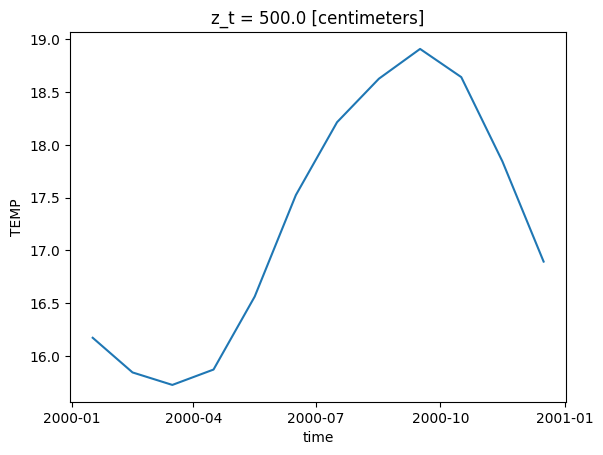

In [16]:
point_3.TEMP.plot()

In [30]:
%%time

#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000_2 = test_2.sel(time=slice("1990","2000"))

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000_2.TEMP.sel(z_t = 0, method = "nearest")

#select a member_id
point_3_1 = point_2.mean("member_id")
point_2


CPU times: total: 46.9 ms
Wall time: 43.1 ms


<xarray.DataArray 'TEMP' (member_id: 40, time: 132)> Size: 21kB
dask.array<getitem, shape=(40, 132), dtype=float32, chunksize=(1, 6), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 1kB 1990-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B 500.0
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

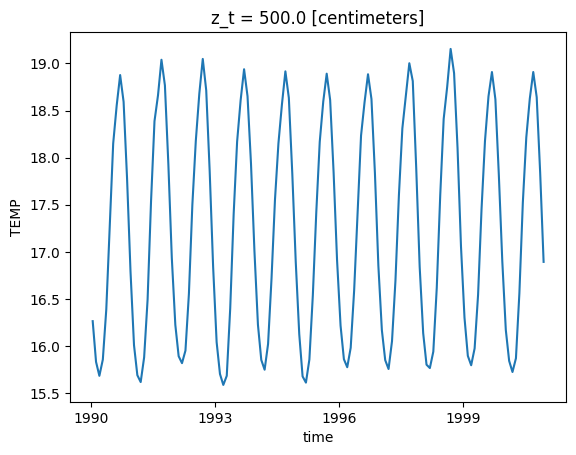

In [24]:
point_3_1.TEMP.plot()

In [31]:
%%time

# save file - don't forget the .nc extension!
point_2.to_netcdf('time_series_1990_2000.nc')

# open to check:
check = xr.open_dataset('time_series_1990_2000.nc'
)
check

CPU times: total: 33min 6s
Wall time: 48min 30s


<xarray.Dataset> Size: 22kB
Dimensions:    (member_id: 40, time: 132)
Coordinates:
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 1kB 1990-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B ...
Data variables:
    TEMP       (member_id, time) float32 21kB ...

In [7]:
#slice for southern california
ds_20C_ch = ds_20C.isel(nlat=slice(240,330), nlon=slice(220,260))
ds_20C_ch

<xarray.Dataset> Size: 143GB
Dimensions:     (member_id: 40, time: 1032, z_t: 60, nlat: 90, nlon: 40, d2: 2)
Coordinates:
  * member_id   (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time        (time) object 8kB 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
  * z_t         (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    time_bound  (time, d2) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    O2          (member_id, time, z_t, nlat, nlon) float32 36GB dask.array<chunksize=(1, 6, 60, 90, 40), meta=np.ndarray>
    SALT        (member_id, time, z_t, nlat, nlon) float64 71GB dask.array<chunksize=(1, 6, 60, 90, 40), meta=np.ndarray>
    TEMP        (member_id, time, z_t, nlat, nlon) float32 36GB dask.array<chunksize=(1, 6, 60, 90, 40), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:vertical_levels:  60.0
    intake_esm_attrs:spatial_domain:   global_ocean
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

In [9]:
%%time
#graph the location
ds_20C_ch_mean=ds_20C_ch.mean(dim="member_id")
ds_20C_ch_mean.TEMP.squeeze().plot()

In [ ]:
%%time

# save file - don't forget the .nc extension!
point_3.to_netcdf('time_series_ch.nc')

# open to check:
check = xr.open_dataset('time_series_ch.nc'
)
check

In [18]:
#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000_2 = test_2.sel(time=slice("1920", "2000"))

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000_2.sel(z_t = 0, method = "nearest")

#select a member_id
point_3 = point_2.mean("member_id")
point_3

<xarray.DataArray 'TEMP' (time: 972)> Size: 4kB
dask.array<mean_agg-aggregate, shape=(972,), dtype=float32, chunksize=(6,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8kB 1920-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t      float32 4B 500.0

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

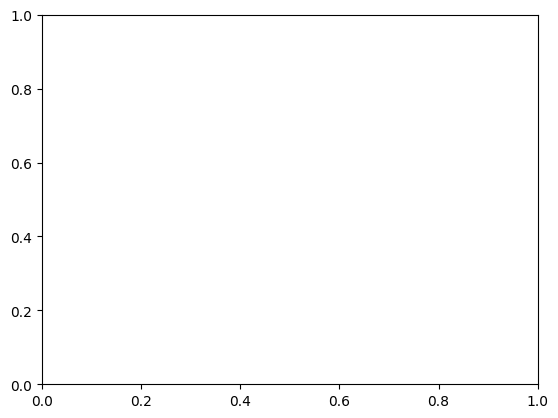

In [22]:
point_3.plot()

In [ ]:
#take the mean of the member_id so it will not show up as a dimension
#look at one member_id
ds_20C_1=ds_20C.mean("member_id")
ds_20C_1

#### Slicing for a specific time frame

As this notebook is concerned with the time between 1950 to 2000, we will be slicing our xarray to feature that time frame using the function `.sel`.

In [ ]:
ds_20C_1.sel(time=slice("1950", "2000"))

At the moment, we are looking at all of the information found in the `xarray`. Let's break it down to a smaller portion to make it easier to deal with. I'll be looking at a specific z_t portion of the `xarray` as well as narrowing down the time variable to have an `xarray` that is easy to work with.

In [ ]:
#select for just one z_t to look at
temp_zt_0 = ds_20C_1.TEMP.sel(z_t = 0, method = "nearest")
#select for just the time containing the year 2000
temp_2000 = temp_zt_0.sel(time='2000')
#print th xarray
temp_2000

point_3 = temp_2000.isel(nlat=(280), nlon=(240))
point_3

In [ ]:
%%time
point_3.plot()

### Data Exploring

This section will cover some data exploration and what are in these xarrays. It is recommended to have a good foundation on what xarrays are and how to understand them. Here is a link that details what xarrays are and how you can manipulate [them](https://earth-env-data-science.github.io/lectures/xarray/xarray_intro.html).

Let's go ahead and load in our dataset from the previous code chunk:

In [ ]:
#print the edited xarray
temp_2000

Here, we have 4 different types of attributes found in this xarray: `Dimensions`, `Coordinates`, `Indexes`, and `Attributes`. `xarrays` usually have a `Data Variable column`, but because we have already included that in our code indicating that is the variable we want to take a look at, it is not included in the information.

Looking at this `xarray`, we know that the `time` dimension contains 12 observations, the `nlat` contains 384 observations, and the `nlon` contains 320 observations. For this notebook, it's important that you pinpoint one particular point on the map in order to correctly render the time series correctly (eg. `isel(nlat = 35, nlot = 60`). Skipping this step will not render the line plot correctly.

## Plotting the time series

Now, we will go ahead and plot the time series. A time series is useful in many scenarios as it can show trends in the data. Multiple statistical methods can be done on this type of series, including different types of regressions. You can read more about this [here](https://doi.org/10.1016/j.earscirev.2018.12.005).

In this section, we will go over how to make a simple time series. This time series will not have any other type of statistical analysis but if you are looking for particular trends with the help of other statistical tools, I recommend looking online to see how this can be achieved. *maybe ask teammate if this section of the notebook is necessary*


### Example code of how to create the time series

Below is an example code of how I created the time series. Parts of this code are very interchangeable with it being:
- `time`
- `z_t`
- `member_id`
- `nlat`
- `nlon`

*A couple of important notes*: 

- When creating a timeseries, it is important to indicate one point when selecting the `nlat` and `nlon` coordinates. If you create a slice to cover a whole area, the plot will create a histogram, counting up the number of times a particular temperature has been recorded for that area. In this example, we have pinpointed `nlat` and `nlon` that is closest to the Channel Island area.

- The time format is in `cftime.DatetimeNoLeap`. Because it is not in a `Datetime` format, an additional package will need to be installed. I recommend running `pip install nc-time-axis` in your terminal to properly install that package.


In [ ]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]
ds_20C


In [ ]:
# Use Dask.Distributed utility function to display size of each dataset (DOES NOT WORK)
# from distributed.utils import format_bytes
# print(f"20th Century: {format_bytes(ds_20C.nbytes)}\n"
#       f"RCP8.5: {format_bytes(ds_RCP85.nbytes)}")



In [ ]:
# Extract the Temperature data variable
t_20c = ds_20C["TEMP"]
t_rcp = ds_RCP85["TEMP"]
t_rcp

In [5]:
from dask.distributed import Client
client = Client()
client.close()

/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38337 instead
  warnings.warn(


In [50]:
from dask.distributed import LocalCluster
cluster = LocalCluster()       
client = cluster.get_client()
client
client.close()

In [15]:
#example code

#slice for particular timeframe
test_2 = ds_20C.sel(time="2000")

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
test_2000_2 = test_2.sel(z_t = 0, method = "nearest")

#select a member_id
point_2 = test_2000_2.sel(member_id = 1)
point_2a = test_2000_2.sel(member_id = 1)
point_2

#select just one point on the graph (this point is closest to channel islands)
point_3 = point_2.isel(nlat=(280), nlon=(240))
point_3a = point_2a.O2.isel(nlat=(280), nlon=(240))
point_3

<xarray.Dataset> Size: 492B
Dimensions:     (time: 12, d2: 2)
Coordinates:
    member_id   int64 8B 1
  * time        (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t         float32 4B 500.0
    time_bound  (time, d2) object 192B dask.array<chunksize=(12, 2), meta=np.ndarray>
Dimensions without coordinates: d2
Data variables:
    O2          (time) float32 48B dask.array<chunksize=(6,), meta=np.ndarray>
    SALT        (time) float64 96B dask.array<chunksize=(6,), meta=np.ndarray>
    TEMP        (time) float32 48B dask.array<chunksize=(6,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:vertical_levels:  60.0
    intake_esm_attrs:spatial_domain:   global_ocean
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

AttributeError: 'Dataset' object has no attribute 'to_csv'

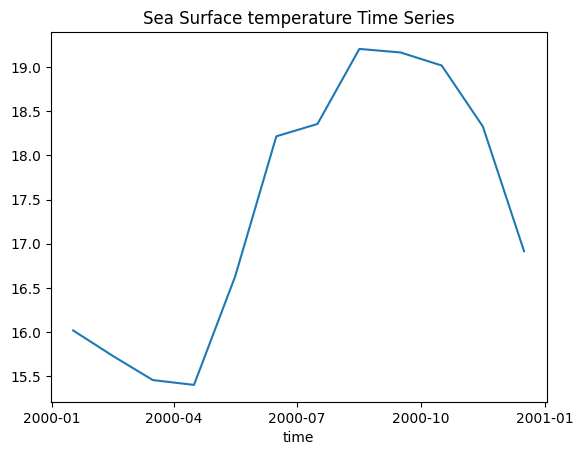

In [47]:
test = point_3.to_array().sel(variable = "TEMP").plot()
plt.title("Sea Surface temperature Time Series")
test

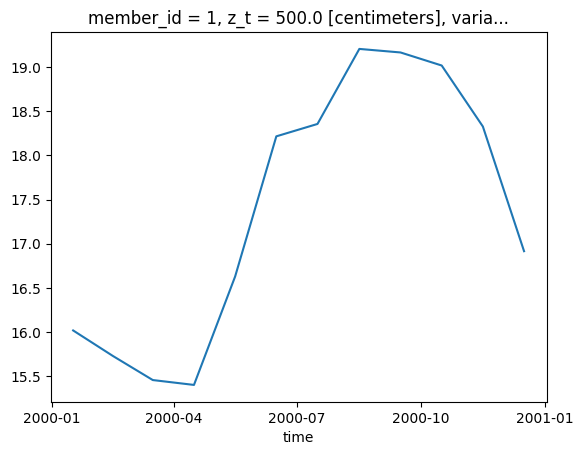

In [45]:
air1d = test.
air1d.plot()

In [67]:
darray = point_3.to_array()
darray

<xarray.DataArray (variable: 3, time: 12)> Size: 288B
dask.array<stack, shape=(3, 12), dtype=float64, chunksize=(1, 6), chunktype=numpy.ndarray>
Coordinates:
    member_id   int64 8B 1
  * time        (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t         float32 4B 500.0
    time_bound  (time, d2) object 192B dask.array<chunksize=(12, 2), meta=np.ndarray>
  * variable    (variable) object 24B 'O2' 'SALT' 'TEMP'
Attributes: (12/19)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:vertical_levels:  60.0
    intake_esm_attrs:spatial_domain:   global_ocean
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

In [73]:
point_3['TEMP']

<xarray.DataArray 'TEMP' (time: 12)> Size: 48B
dask.array<getitem, shape=(12,), dtype=float32, chunksize=(6,), chunktype=numpy.ndarray>
Coordinates:
    member_id  int64 8B 1
  * time       (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B 500.0
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

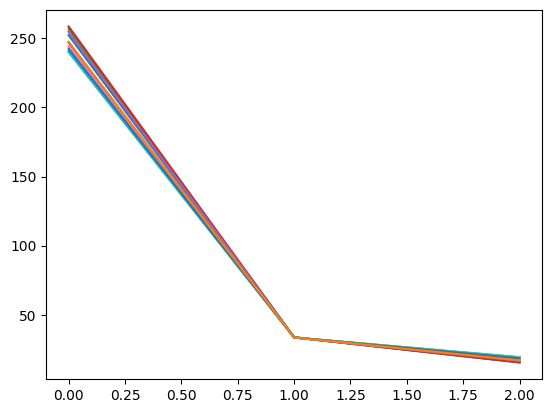

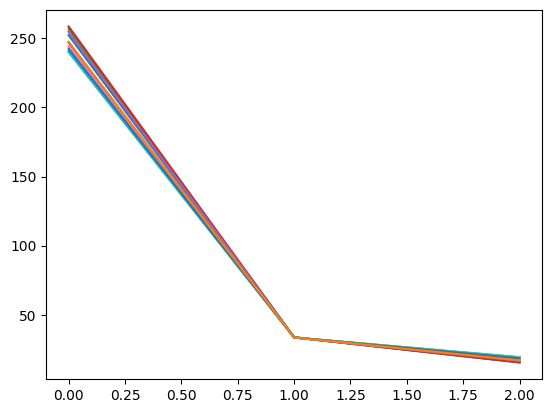

In [68]:
fig, ax = plt.subplots()
ax.plot(darray)
fig

AttributeError: Line2D.set() got an unexpected keyword argument 'title'

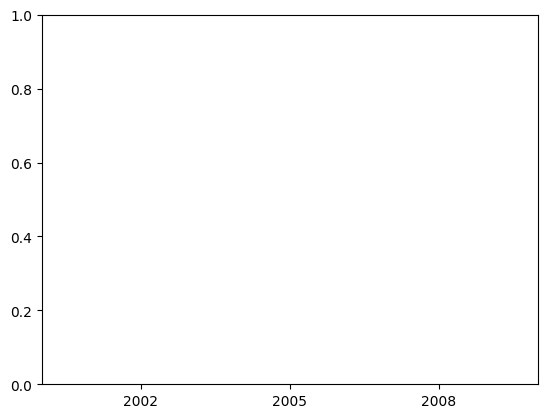

In [50]:
point_3.plot()

#.title("Sea Surface temperature Time Series")


Text(0.5, 1.0, 'Sea Surface temperature Time Series')

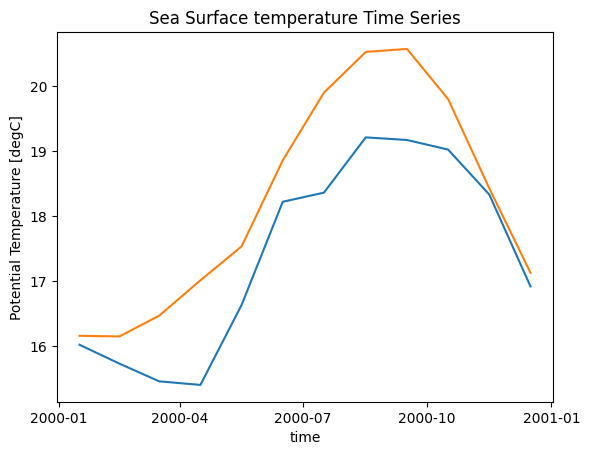

In [11]:
#plot out time series graph
point_3.plot()
point_3a.plot()

#add title to graph
plt.title("Sea Surface temperature Time Series")

In [14]:
%%time

# save file - don't forget the .nc extension!
point_3.to_netcdf('time_series_temp_test.nc')



CPU times: total: 922 ms
Wall time: 16.2 s


In [11]:
# open to check:
check = xr.open_dataset('time_series_temp_test.nc'
)
check

<xarray.Dataset> Size: 156B
Dimensions:    (time: 12)
Coordinates:
    member_id  int64 8B ...
  * time       (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B ...
Data variables:
    TEMP       (time) float32 48B ...

In [8]:
%%time

# save file - don't forget the .nc extension!
point_3a.to_netcdf('time_series_temp_o2.nc')

CPU times: total: 2.83 s
Wall time: 16.4 s


In [9]:
check_o2 = xr.open_dataset('time_series_temp_o2.nc'
)
check_o2

<xarray.Dataset> Size: 156B
Dimensions:    (time: 12)
Coordinates:
    member_id  int64 8B ...
  * time       (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B ...
Data variables:
    O2         (time) float32 48B ...

In [12]:
#test to combine two arrays together
merge_test = xr.merge([check, check_o2])
merge_test

<xarray.Dataset> Size: 204B
Dimensions:    (time: 12)
Coordinates:
    member_id  int64 8B 1
  * time       (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B 500.0
Data variables:
    TEMP       (time) float32 48B ...
    O2         (time) float32 48B ...

In [65]:
darray = merge_test.to_array()

df = darray.to_dataset("variable")
darray
#df.to_csv("variable_temp.csv")

<xarray.DataArray (variable: 2, time: 12)> Size: 96B
array([[ 16.017298,  15.727551,  15.455164,  15.400044,  16.629057,
         18.216425,  18.356829,  19.206913,  19.166784,  19.018934,
         18.327612,  16.915266],
       [252.24529 , 255.1608  , 256.89313 , 258.6236  , 254.6365  ,
        247.0109  , 244.31775 , 240.73251 , 239.97484 , 240.22795 ,
        242.30074 , 247.54137 ]], dtype=float32)
Coordinates:
    member_id  int64 8B 1
  * time       (time) object 96B 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t        float32 4B 500.0
  * variable   (variable) object 16B 'TEMP' 'O2'

In [57]:
    
#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000_2 = test_2.sel(time=slice("1950", "2000"))

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000_2.sel(z_t = 0, method = "nearest")

#select a member_id
point_3 = point_2.mean("member_id")

In [58]:
point_3

<xarray.Dataset>
Dimensions:     (time: 612, d2: 2)
Coordinates:
  * time        (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t         float32 500.0
    time_bound  (time, d2) object dask.array<chunksize=(612, 2), meta=np.ndarray>
Dimensions without coordinates: d2
Data variables:
    O2          (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    SALT        (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    SST         (time) float32 dask.array<chunksize=(240,), meta=np.ndarray>
    TEMP        (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>

In [59]:
%%time

point_3.TEMP.plot()

KeyboardInterrupt: 

In [ ]:
%%time

# save file - don't forget the .nc extension!
point_3.to_netcdf('time_series_ch.nc')

# open to check:
check = xr.open_dataset('time_series_ch.nc'
)
check

NameError: name 'check' is not defined

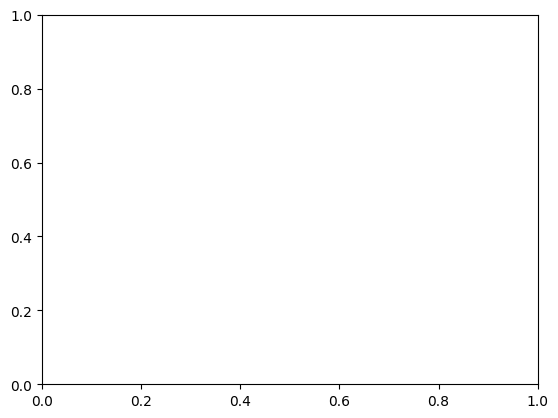

In [11]:
%%time

ax = plt.axes()

#plot out time series graph
ax.plot(check)

#add title to graph
#plt.title("Sea Surface temperature Time Series")

In [47]:
check = xr.open_dataset('time_series_ch.nc'
)
check

<xarray.Dataset>
Dimensions:  (time: 612)
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
    z_t      float32 ...
Data variables:
    TEMP     (time) float32 ...

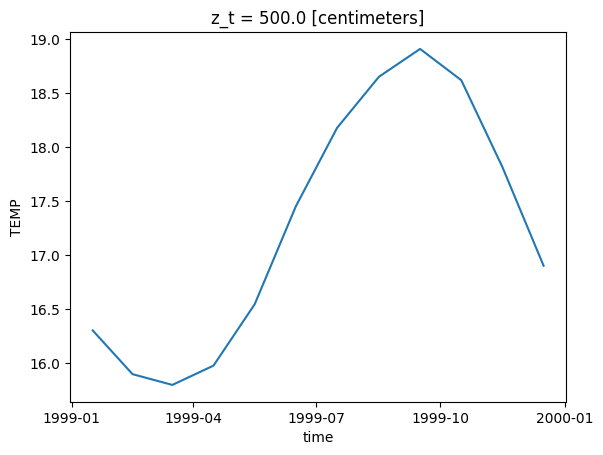

In [48]:
check.TEMP.plot()

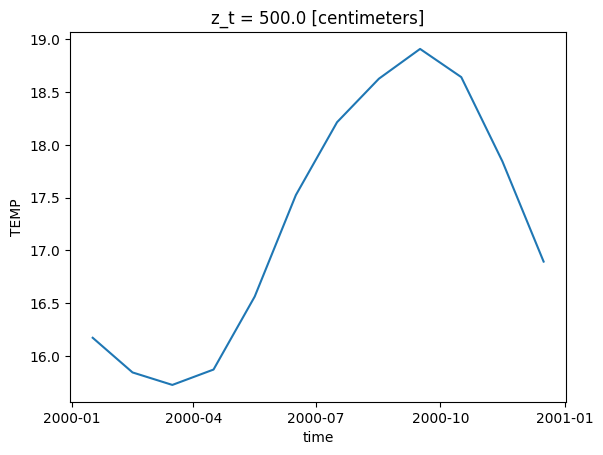

In [57]:
#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000_2 = test_2.sel(time="2000")

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000_2.sel(z_t = 0, method = "nearest")

#select a member_id
point_3 = point_2.mean("member_id")
point_3.plot()

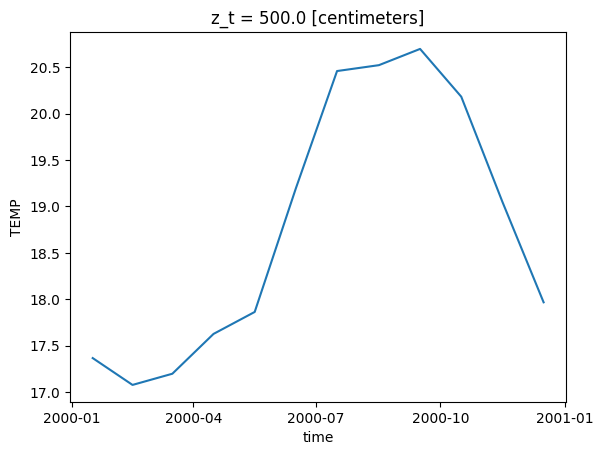

In [58]:
#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000_2 = test_2.sel(time="2000")

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000_2.sel(z_t = 0, method = "nearest")

#select a member_id
point_3 = point_2.max("member_id")
point_3.plot()

CPU times: user 20min 54s, sys: 6min 11s, total: 27min 6s
Wall time: 34min 21s


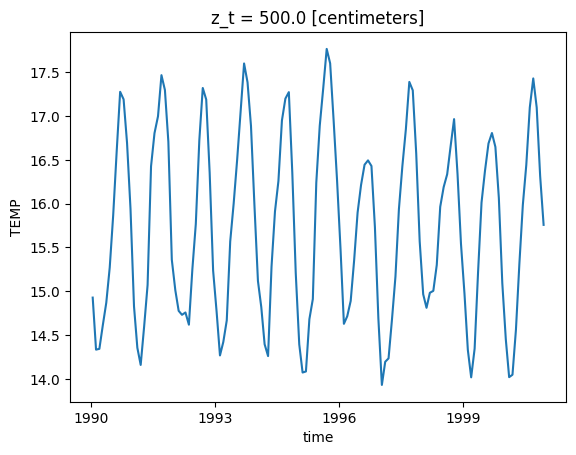

In [62]:
%%time

#select just one point on the graph (this point is closest to channel islands)
test_2 = ds_20C.isel(nlat=(280), nlon=(240))

#slice for particular timeframe
test_2000_2 = test_2.sel(time=slice("1990","2000"))

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
point_2 = test_2000_2.sel(z_t = 0, method = "nearest")

#select a member_id
point_3 = point_2.min("member_id")
point_3.plot()

In [43]:
test_2 = z.sel(time=slice("1920", "2000"))

#select the TEMP column and set z_t, which is depth to 0 for sea surface temeperature
test_2000_2 = test_2.TEMP.sel(z_t = 0, method = "nearest")

#select a member_id
point_2 = test_2000_2.sel(member_id = 2)

#select just one point on the graph (this point is closest to channel islands)
point_3 = point_2.isel(nlat=(280), nlon=(240))


            #plot out time series graph
point_3.plot()
            #add title to graph
plt.title("Sea Surface temperature Time Series")


KeyboardInterrupt: 

And there you have it! You have sucessfully created a time series graph for the Channel Islands. If you feel you want to customize the graph even more than the basic layout here, check out the xarray link [here](https://docs.xarray.dev/en/stable/user-guide/plotting.html).